# Understanding eddy momentum flux 
## from 7km G5NR data, and G5NRutils.py
### Suvarchal Cheedela and Brian Mapes, Oct 2017 

https://github.com/suvarchal/G5NR_Interactive_notebooks

----------
#### Geoviews is an Earth-specific Holoviews. It displays 1-2 dimensions of a multi-D object, and the other dims become interactive sliders.
#### xarray is the netCDF-friendly front end for reading in the data. Cartopy has the background maps. 

In [1]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs as ccrs
import xarray as xr
import numpy as np
from datetime import datetime

#### Bokeh is a plotting package with pan-zoom interactivity 


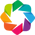

In [2]:
hv.notebook_extension('bokeh') #other backend is matplotlib but can be changed on the fly just before plottting

### Connect to the 3D data set as an xarray *dataset* object

In [3]:
# 7km data grids from unzipping of .zidv bundle
xrdata_3d = xr.open_dataset('data_0_3D7km30minuteInst.nc')

# remote whole dataset 
#xrdata_3d = xr.open_dataset('http://weather.rsmas.miami.edu/repository/opendap/synth:1142722f-a386-4c17-a4f6-0f685cd19ae3:L0c1TlIvR0VPUzUtTmF0dXJlLVJ1bi1JbnN0MzBtaW4tN2ttX3ByZXNzdXJlX21ldGhvZDIubmNtbA==/entry.das')

print(xrdata_3d.data_vars)

Data variables:
    u        (time, lev, lat, lon) float64 -24.83 -24.86 -24.83 -24.64 ...
    v        (time, lev, lat, lon) float64 -14.41 -14.58 -14.73 -14.89 ...
    w        (time, lev, lat, lon) float64 0.1658 0.1758 0.1835 0.1642 ...
    airdens  (time, lev, lat, lon) float64 2.52e-05 2.52e-05 2.519e-05 ...


### Subset data in time and space. 
#### Use .sel( ) to select by coordinate values, or .isel( ) to select by index. Use slice(value1,value2) to select ranges. 

In [4]:
#xrdata_3d.sel(time=slice(datetime(2005,6,1,0,30),datetime(2005,6,1,2,30)),lat=slice(0,5),lon=slice(-14,-10))
#xrdata_3d.isel(time=0)

### Merge total fields (U,V,W) with total flux (UW, VW, UV) as a Geoview (Holoview) Image object. 

1. First, create and name a new xarray dataset of the product terms. 
1. Next, merge these into the xarray set. 
1. Finally, convert the merged set into a Geoviews object. 

In [5]:
# XARRAY computations
uw=xrdata_3d.u*xrdata_3d.w
uw.name='uw'
vw=xrdata_3d.v*xrdata_3d.w
vw.name='vw'
uv=xrdata_3d.u*xrdata_3d.v
uv.name='uv'

# Merge derived with raw fields 
xrdata_3d_all=xr.merge([xrdata_3d,uw,vw,uv])

# GEOVIEWS conversion
subgrid_gv=gv.Dataset(xrdata_3d_all)

# GEOVIEWS display (Image) creation
# dynamic = True is faster to execute but slower to interact: images are made on the fly during interaction
# dynamic = False is slower to execute, but faster to interact: all images are precomputed now

U_img   =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['u'],label='U',dynamic=True).redim.range(u=(-15,15))
V_img   =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['v'],label='V',dynamic=True).redim.range(v=(-15,15))
W_img   =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['w'],label='W',dynamic=True).redim.range(w=(-2,2))
UW_img=subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['uw'],label='UW',dynamic=True).redim.range(uw=(-50,50))
VW_img=subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['vw'],label='VW',dynamic=True).redim.range(vw=(-50,50))
UV_img=subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['uv'],label='UV',dynamic=True).redim.range(vw=(-50,50))

### Geoviews multiple-displays creation. So simple! 
* **(U_img+V_img+W_img+UW_img+VW_img+UV_img).cols(3)** 
* Options include 
  * %%output backend='bokeh' or 'matplotlib'
  * %%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
  * %%output size=100

In [6]:
%%output backend='bokeh' #backend changed to bokeh, gives more options for tooltip
%%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
%%output size=90

# Here is the Magic Command to Create the Displays! 
(U_img+V_img+W_img+UW_img+VW_img+UV_img).cols(3)     # cols specifies how many columns of plots

:Layout
   .DynamicMap.I   :DynamicMap   [lev,time]
   .DynamicMap.II  :DynamicMap   [lev,time]
   .DynamicMap.III :DynamicMap   [lev,time]
   .DynamicMap.IV  :DynamicMap   [lev,time]
   .DynamicMap.V   :DynamicMap   [lev,time]
   .DynamicMap.VI  :DynamicMap   [lev,time]

-------------
### G5NR_utils.py has computations with 7km gridded u,v,w inputs
#### (90,45) is the 4 degree scale (divides the world into 90x45 arrays) 

* In particular, **subgrid** returns the prime terms up, vp, wp 

In [7]:
from G5NR_utils import subgrid

subgrid_xr = subgrid(xrdata_3d,90,45)

#### Merge the prime terms, and their products, back into the Subgrid xarray dataset

In [8]:
# XARRAY computations
upwp =subgrid_xr.u*subgrid_xr.w
upwp.name ='upwp'
vpwp =subgrid_xr.v*subgrid_xr.w
vpwp.name ='vpwp'
upvp =subgrid_xr.u*subgrid_xr.v
upvp.name ='upvp'

# Merge these derived fields back with the raw fields 
subgrid_xr =xr.merge([subgrid_xr,upwp,vpwp,upvp])

subgrid_xr

<xarray.Dataset>
Dimensions:   (lat: 172, lev: 72, lon: 241, time: 5)
Coordinates:
  * time      (time) datetime64[ns] 2005-08-12T02:30:00 2005-08-12T03:00:00 ...
  * lev       (lev) float64 0.01 0.02 0.0327 0.0476 0.066 0.0893 0.1197 ...
  * lon       (lon) float64 -71.5 -71.44 -71.38 -71.31 -71.25 -71.19 -71.12 ...
  * lat       (lat) float64 35.56 35.62 35.69 35.75 35.81 35.88 35.94 36.0 ...
Data variables:
    u         (time, lev, lat, lon) float64 -3.721 -3.752 -3.721 -3.533 ...
    v         (time, lev, lat, lon) float64 -1.497 -1.669 -1.825 -1.982 ...
    w         (time, lev, lat, lon) float64 0.1328 0.1427 0.1504 0.1312 ...
    airdens   (time, lev, lat, lon) float64 3.33e-07 3.33e-07 3.255e-07 ...
    lon_bins  (lat, lon) object (-74.0, -70.0] (-74.0, -70.0] (-74.0, -70.0] ...
    lat_bins  (lat) object (34.773, 38.864] (34.773, 38.864] ...
    upwp      (time, lev, lat, lon) float64 -0.494 -0.5355 -0.5597 -0.4635 ...
    vpwp      (time, lev, lat, lon) float64 -0.1988 -0.23

### Make a Geoviews Dataset, and 6 Images, for subgrid (prime) terms

In [9]:
# GEOVIEWS conversion
subgrid_gv = gv.Dataset(subgrid_xr)
subgrid_gv.vdims

[Dimension('u'),
 Dimension('v'),
 Dimension('w'),
 Dimension('airdens'),
 Dimension('lon_bins'),
 Dimension('lat_bins'),
 Dimension('upwp'),
 Dimension('vpwp'),
 Dimension('upvp')]

In [12]:
# GEOVIEWS display (Image) creation
# dynamic = True is faster to execute but slower to interact: images are made on the fly during interaction
# dynamic = False is slower to execute, but faster to interact: all images are precomputed now

u_img    =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['u'],label='up',dynamic=True).redim.range(u=(-15,15))
v_img    =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['v'],label='vp',dynamic=True).redim.range(v=(-15,15))
w_img    =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['w'],label='wp',dynamic=True).redim.range(w=(-2,2))
upwp_img =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['upwp'],label='upwp',dynamic=True).redim.range(upwp=(-20,20))
vpwp_img =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['vpwp'],label='vpwp',dynamic=True).redim.range(vpwp=(-20,20))

In [13]:
# Totally effing bizarre that this one doesn't work! ???

upvp_img =subgrid_gv.to(hv.Image,kdims=['lon','lat'],vdims=['upvp'],label='upvp',dynamic=True).redim.range(upvp=(-20,20))

### The Geoviews display for these perturbation quantities:

In [14]:
%%output backend='bokeh' #backend changed to bokeh, gives more options for tooltip
%%opts Image (cmap='RdBu_r') [width=300 height=200 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
%%output size=90

(u_img + v_img + w_img + upwp_img + vpwp_img + upvp_img).cols(3) 

:Layout
   .DynamicMap.I   :DynamicMap   [lev,time]
   .DynamicMap.II  :DynamicMap   [lev,time]
   .DynamicMap.III :DynamicMap   [lev,time]
   .DynamicMap.IV  :DynamicMap   [lev,time]
   .DynamicMap.V   :DynamicMap   [lev,time]
   .DynamicMap.VI  :DynamicMap   [lev,time]

-------------
## Now let's look at SKEdot, computed as a function of resolution

In [15]:
from G5NR_utils import SKEDot, regrid

TIMELEVEL = 2 # hardwired in function below for now

def plot_skedot(nlon,nlat):
    skedot = SKEDot(xrdata_3d.airdens.isel(time=0),xrdata_3d.u.isel(time=TIMELEVEL),xrdata_3d.v.isel(time=0),xrdata_3d.w.isel(time=0),nlon,nlat)
    gv_dataset=gv.Dataset(skedot.SKEDOT).redim.range(SKEDOT=(-1,1)) # W m-2 units
    
    return hv.Image(gv_dataset)

#### Resolution as a slider (or menu) 

In [17]:
mesh_latlon={'4 deg':(90,45),'2 deg':(180,91),'1 deg':(360,181),'.5 deg':(720,361)}

# A dictionary of images as a function of resolution
img_dict = {res:plot_skedot(mesh_latlon[res][0],mesh_latlon[res][1]) for res in mesh_latlonres}

# HoloMap is a static map, very slow to display for heavy dataset
# DynamicMap can be constructed directly from hv.DynamicMap(plot_function)
# here holomap is used because gives this dropdown widget, havent figured how to do wih dynamic map
# but before displaying holomap it is converted to a dynamicmap, so still ok to use in this case

hmap = hv.HoloMap(img_dict,kdims=['Resolution'])

### The magic plot: SKEdot as a function of resolution
# WHY IS IT BLUE NOT RED? SKEdot function must be in error

In [18]:
%%output backend='bokeh'
%%opts Image (cmap='RdBu_r') [width=600 height=400 colorbar=True toolbar='above'] Feature.Lines (line_color='gray' line_width=0.5)
hv.util.Dynamic(hmap)

:DynamicMap   [Resolution]